# Calculation of detectable Gamma ray burst (GRB) event rate associated with Binary Neutron Star (BNS) mergers.

* This is without considering a particular detectors' sensitivity, but rather a general calculation of the rate of detectable GRBs based of viewing angle and luminosity distance. I have considered the inclination angle gravitational waves same as the viewing angle wrt GRB jet axis.

* It involves constructing Pdet (detection probability) function based off luminosity function.

* For BNS source redshift and mass distribution, refer [here](https://ler.readthedocs.io/en/latest/GW_events.html).

* For lens and image properties, refer [here](https://ler.readthedocs.io/en/latest/Lensed_events.html).

* Both SWIFT and FERMI detectors are considered.

* All analysis will be limited to redshift $z\in [0,5]$.

## Result summary


### Condition 1 (EM->GW)

Steps:
1. Sample GRB detectable events from BNS merger events.
2. Calculate rate
3. Check, out of these GRB detectable events, how many are detectable in GWs.

| Event | Unlensed | Lensed | ratio(Unlensed/Lensed) |
| --- | --- | --- | --- |
| GRB | 11593.12 | 9.23 | 1:1256.03 |
| GW(snr>8) | 2.03 | 3.69e-3 | 1:550.13 |
| ratio, GW(snr>8)/GRB | 1:5710.9 | 1:2501.35 | - |
| GW(snr>6) | 4.69 | 9.78e-3 | 1:479.55 |
| ratio, GW(snr>6)/GRB | 1:2469.13 | 1:943.39 | - |


### Condition 2 (GW->EM)

Steps:
1. Sample GW detectable events from BNS merger events.
2. Calculate rate
3. Check, out of these GW detectable events, how many are detectable in GRBs.

I will consider super-threshold events only (snr>8).

| Event | Unlensed | Lensed | ratio(Unlensed/Lensed) |
| --- | --- | --- | --- |
| GW(snr>8) | 3.0 | 6.63e-3 | 1:452.83 |
| GRB | 0.123 | 1.54-4 | 1:12520.33 |
| ratio(GW(snr>8)/GRB) | 24.39 | 4.31 | - |


## Equations (GRB)

* Ref: [Howell et. al. (2019)](https://arxiv.org/pdf/1811.09168)

* The luminosity function of GRBs is given by:

$$L(\theta_{V})=L_{c}\text{exp}(-\frac{\theta^{2}}{2\theta_{c}^{2}})$$

* Here, $L(\theta_{V})$ is the luminosity at viewing angle $\theta_{V}$, $L_{c}$ is the luminosity at the jet axis, $\theta$ is the viewing angle, and $\theta_{c}$ is the core angle of the jet.

* The paper gives: $\theta_{c} = 5$ degree.

* I will infer the probability of detection from the above equations.

$$P_{det}(\theta,D_L) = \left\{ 
  \begin{array}{ c l }
    1 & \text{if } \theta \le 5 \text{ deg and } D_L \le 46652 \text{ Mpc } (z\sim 5) \\
    1 & \text{if } \frac{\text{a}}{4\pi D_L^2} \text{exp}(-\frac{\theta^{2}}{2\times 21.2^2}) \ge 1 \\
    0 & \text{otherwise}
  \end{array}
\right.$$

* Coefficients a is solved by considering conditions 2 below.,
  1. If angle <= 5 deg, distance <= distance_cut, then $P_{det}$ = 1.
  2. pdet=1, If angle=21.2 deg (at distance=40Mpc). This is by considering the GRB from GW170817 would have been difficult to detect if viewing angle>21.2 deg (at distance=40Mpc) or distance>40 Mpc (at angle=21.2 deg).

In [3]:
from ler.rates import LeR
import numpy as np
import matplotlib.pyplot as plt
from ler.utils import get_param_from_json

## Probability of detection of GRBs

### Finding the coefficients

In [4]:
import numpy as np
from scipy.optimize import fsolve

# to find coefficient a
# consider: pdet = 1, If angle = 21.2 deg (at distance=40). 
def equation(a):
    angle = 21.2
    distance = 40
    return a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2) - 1

a_guess = 10000

# Solve the equation
a_solution = fsolve(equation, a_guess)

print(f"a = {a_solution[0]}")

a = 161107621.34601912


### Function to calculate the probability of detection

In [5]:
# Find distance_cut, z=5
# convert redshift to luminoisty distance
import astropy.units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
z = 5
d_L = cosmo.luminosity_distance(z)
print(f"d_L = {d_L}")

d_L = 46652.22297277721 Mpc


In [6]:
# interpolation to convert luminoisty distance to redshift
from scipy import interpolate
z = np.geomspace(0.0001, 10, 1000)
d_L = cosmo.luminosity_distance(z)
dl_to_z = interpolate.interp1d(d_L, z)

In [7]:
# distance_cut: z ~ 5
def pdet_grb(angle, distance, distance_cut=46652, duty_cycle=0.5, mask_duty_cycle=True, bool=True, pdet_cut=0.5):
    """
    Function to calculate the probability of detection for a given angle and distance for GRB. Coefficient involved is based on 2 the following conditions,

    Note: GRB jet, core angle <= 5 deg
    1. If angle <= 5 deg, distance <= distance_cut, then pdet(bool) = 1
    2. pdet=1, If angle=21.2 deg (at distance=40Mpc). This is by considering the GRB from GW170817 would have been difficult to detect if viewing angle<21.2 deg (at distance=40Mpc) or distance<40 Mpc (at angle=21.2 deg).

    Parameters
    ----------
    angle : numpy.ndarray
        Angle between the GRB jet and viewing angle in (rad)
    distance : numpy.ndarray
        Distance between the GRB source and the satellite in (Mpc)
    distance_cut : float
        Core angular size of the GRB jet in (rad)
        default is 25422.742 Mpc
    duty_cycle : float
        Duty cycle of detector(s)
        default is 0.5 (50%: for Fermi-GBM and Swift-BAT combined)
    bool : bool
        if True, return absolute value of pdet
        if False, return the pdet value as boolean (with duty cycle applied)
    """

    # coefficients, obtained with scipy.optimize fsolve by considering the condition 2,3 listed in docstring

    a = 161107621.34601912
    jet_angle_cut = 5

    # convert angle to degree
    angle = np.degrees(angle)

    # make sure that the input data is a numpy array
    angle, distance = np.array([angle]).reshape(-1), np.array([distance]).reshape(-1)

    # angle should be less than 90 or equal to 90
    if len(angle[angle > 90]) > 0:
        angle[angle > 90] = angle[angle > 90]%90

    if bool:
        # calculate the probability of detection, absolute value
        pdet = abs(a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/jet_angle_cut)**2))

        # find idx of angle <= jet_angle_cut and distance <= distance_cut
        idx = (angle <= jet_angle_cut) & (distance <= distance_cut)
        # apply the condition, condition 1 from docstring
        pdet[idx] = 1

        if mask_duty_cycle:
            # apply the duty cycle
            # sample random numbers from 0 to 1 and check if it is less than the duty cycle
            num_ = np.random.rand(len(angle))
            mask_duty_cycle = num_ > duty_cycle
            pdet[mask_duty_cycle] = 0

        # return the pdet as boolean
        return (pdet>=pdet_cut).astype(int)
    else:
        # return the probability of detection (absolute value)
        return abs((1 / (1 + (angle / 5)**c))* (40/distance)**2 * a/(4*np.pi))

### test

In [8]:
angle = np.array([1, 1, 20, 90])
angle = np.radians(angle)
distance = np.array([46652, 46653, 40, 40])
print(pdet_grb(angle, distance, mask_duty_cycle=False, bool=True))

[1 0 1 0]


### Plot detection and non-detection

In [9]:
# generate random data
angle = np.random.uniform(0, 30, 5000)
log10_distance = np.random.uniform(0, 5, 5000)
distance = 10**log10_distance
redshift = dl_to_z(distance)

pdet = pdet_grb(np.radians(angle), distance, mask_duty_cycle=False, bool=True)

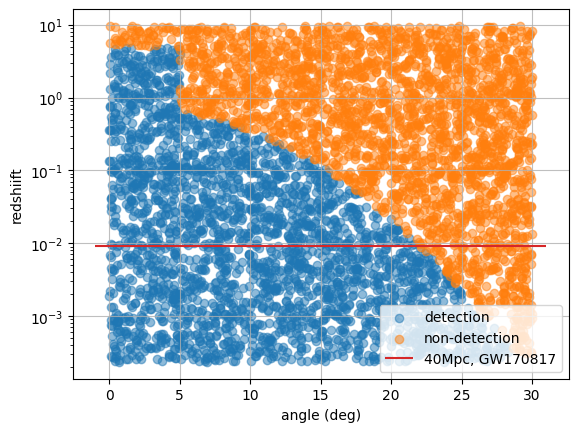

In [10]:
# blue: detection, red: non-detection
plt.scatter(angle[pdet==1], redshift[pdet==1], c='C0', label="detection", alpha=0.5)
plt.scatter(angle[pdet==0], redshift[pdet==0], c='C1', label="non-detection", alpha=0.5)

# draw a horizontal line for GW170817, 40Mpc
plt.hlines(y=dl_to_z(40), xmin=min(angle)-1, xmax=max(angle)+1, colors='C3', linestyles='solid', label='40Mpc, GW170817')

plt.xlabel("angle (deg)")
plt.ylabel("redshiift")
plt.yscale("log")
plt.legend()
plt.grid(alpha=0.8)
plt.show()

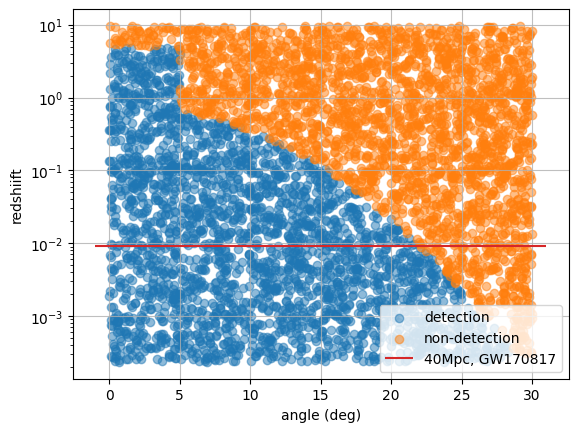

In [11]:
# blue: detection, red: non-detection
plt.scatter(angle[pdet==1], redshift[pdet==1], c='C0', label="detection", alpha=0.5)
plt.scatter(angle[pdet==0], redshift[pdet==0], c='C1', label="non-detection", alpha=0.5)

# draw a horizontal line for GW170817, 40Mpc
plt.hlines(y=dl_to_z(40), xmin=min(angle)-1, xmax=max(angle)+1, colors='C3', linestyles='solid', label='40Mpc, GW170817')

plt.xlabel("angle (deg)")
plt.ylabel("redshiift")
plt.yscale("log")
plt.legend()
plt.grid(alpha=0.8)
plt.show()

### Pdet condition checks

In [12]:
print("condition 1, pdet(angle=core_angle,distance=distance_cut): ", pdet_grb(angle=np.radians(5), distance=46652, mask_duty_cycle=False, bool=True))

print("condition 2")
print("  i) Detectable, pdet(angle=21.2deg,distance=40Mpc): ", pdet_grb(angle=np.radians(21.2), distance=40, mask_duty_cycle=False, bool=True))
print("  ii) Not-Detectable, pdet(angle=21.3deg,distance=40Mpc): ", pdet_grb(angle=np.radians(21.3), distance=40, mask_duty_cycle=False, bool=True))
print("  iii) Not-Detectable, pdet(angle=21.2deg,distance=50Mpc): ", pdet_grb(angle=np.radians(21.2), distance=50, mask_duty_cycle=False, bool=True))

condition 1, pdet(angle=core_angle,distance=distance_cut):  [1]
condition 2
  i) Detectable, pdet(angle=21.2deg,distance=40Mpc):  [1]
  ii) Not-Detectable, pdet(angle=21.3deg,distance=40Mpc):  [1]
  iii) Not-Detectable, pdet(angle=21.2deg,distance=50Mpc):  [1]


* let's write out the function so that it can be used in with LeR
  
* consider 50% duty cycle, i.e. it assume 50% of the sky is observable at any given time with SWIFT and FERMI detectors.

In [13]:
from gwsnr.utils import save_json_dict

# let's write out the function so that it can be used in with LeR
def pdet_calculator(gw_param_dict, duty_cycle=0.5, mask_duty_cycle=True, bool=True, output_jsonfile=False):
    """
    Function to calculate the probability of detection for a given angle and distance for GRB. This is based on the following condition

    Note: GRB jet, core angle <= 5 deg
    1. If angle <= 5 deg, distance <= distance_cut, then pdet(bool) = 1
    2. pdet=1, If angle=21.2 deg (at distance=40Mpc). This is by considering the GRB from GW170817 would have been difficult to detect if viewing angle<21.2 deg (at distance=40Mpc) or distance<40 Mpc (at angle=21.2 deg).

    Parameters
    ----------
    gw_param_dict : dict
        dictionary containing the parameters for the GW event
    """

    # get the angle and distance from the dictionary
    angle = gw_param_dict['theta_jn']
    if 'luminosity_distance' in gw_param_dict:
        distance = gw_param_dict['luminosity_distance']
    elif 'effective_luminosity_distance' in gw_param_dict:
        distance = gw_param_dict['effective_luminosity_distance']

    # calculate the probability of detection
    pdet = pdet_grb(angle, distance, duty_cycle=duty_cycle, mask_duty_cycle=mask_duty_cycle, bool=bool)
    pdet_net_dict = dict(pdet_net=pdet)

    # Save as JSON file, if output_jsonfile is provided
    if output_jsonfile:
        output_filename = (
            output_jsonfile if isinstance(output_jsonfile, str) else "pdet.json"
        )
        save_json_dict(pdet_net_dict, output_filename)

    # return the pdet
    return pdet_net_dict

In [14]:
# test
gw_param_dict = {'theta_jn': np.radians(np.array([1, 21.2, 90])), 'luminosity_distance': np.array([2500, 40, 40])}
print(pdet_calculator(gw_param_dict, mask_duty_cycle=False, bool=True))

{'pdet_net': array([1, 1, 0])}


## Rate calculation of GRB with LeR

All the necessary functions and parameters are defined below.

**Source related:**
* source frame mass: m1 and m2 sample from [double Gaussian](https://ler.readthedocs.io/en/latest/GW_events.html#BNS-mass-distribution:-Bimodal-Gaussian-Model) model lim[1,2.3]Mo
* Geocent time period: uniform prior, 1 year GPS: {'min_': 1238166018, 'max_': 1269702018}
* Redshift: 0 to 5, uniform, 
  * this follows [merger rate density distribution](https://ler.readthedocs.io/en/latest/GW_events.html#Merger-Rate-Density-Formula)
* ra:  sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}
* dec:  sampler_cosine [-np.pi/2, np.pi/2]
* phase : sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}
* psi: sampler_uniform {'min_': 0.0, 'max_': 3.141592653589793}
* theta_jn:   sampler_sine  [0, np.pi]

**Lens related**
* Optical depth: SIE , 
  * so zs for lensed are rejection sampled with optical depth. 
* Lens redshifts: SDSS catalogue (0 to zs), the function of zs Reenske et al. 2021 ( eqnC13). [`ler` function](https://github.com/hemantaph/ler/blob/bce3330638a13ee0883d19633abb17b98791c901/ler/lens_galaxy_population/jit_functions.py#L218)
* Velocity dispersion: gengamma, Haris et al 2018, a=2.32 / 2.67, c=2.67, vd_min=0., vd_max=600.(https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gengamma.html) use in Haris et al upto zs~1.5 (with a=2.32 / 2.67, c=2.67)
* Axis ratio: Raleigh (with Velocity dispersion dependence) {'q_min': 0.2, 'q_max': 1.0}
* axis_rotation_angle : uniform {'phi_min': 0.0, 'phi_max': 6.283185307179586}
* shear: normal {'scale': 0.05}
* mass_density_spectral_index: normal {'mean': 2.0, 'std': 0.2}

**Image related:**
* Strong lensing condition: num_images>=2
* Lens equation solver: EPL+Shear, `lenstronomy`
* Source position: sample within caustic,  Ewoud et. al. 2022

In [30]:
# from ler.rates import LeR
# import numpy as np
# import matplotlib.pyplot as plt
ler = LeR(
    npool=6,
    verbose=False,
    z_max=5,
    pdet_finder=pdet_calculator,
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
    event_type='BNS',
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

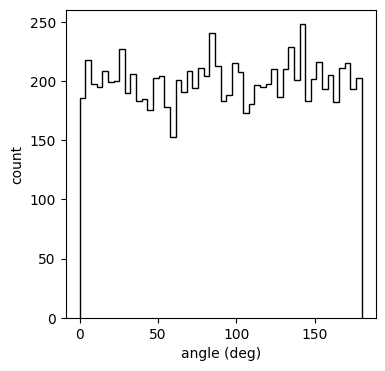

In [31]:
inclination = ler.sample_theta_jn(10000)
plt.figure(figsize=(4, 4))
plt.hist(np.degrees(inclination), bins=50, histtype='step', color='k')
plt.xlabel('angle (deg)')
plt.ylabel('count')
plt.show()

### Unlensed events

In [38]:
unlensed_param_detectable = ler.selecting_n_unlensed_detectable_events(
    size=200000,
    batch_size=200000,
    resume=True,
    trim_to_size=True,
    detectability_condition="pdet",
    output_jsonfile="n_unlensed_params_detectable_grb2.json",
    meta_data_file="meta_unlensed_grb2.json",
)

collected number of detectable events =  0
collected number of detectable events =  5728
total number of events =  200000
total unlensed rate (yr^-1): 11833.706398639886
collected number of detectable events =  11283
total number of events =  400000
total unlensed rate (yr^-1): 11655.002557249813
collected number of detectable events =  16804
total number of events =  600000
total unlensed rate (yr^-1): 11572.020619340354
collected number of detectable events =  22399
total number of events =  800000
total unlensed rate (yr^-1): 11568.74954709911
collected number of detectable events =  28018
total number of events =  1000000
total unlensed rate (yr^-1): 11576.703417496241
collected number of detectable events =  33604
total number of events =  1200000
total unlensed rate (yr^-1): 11570.643325765095
collected number of detectable events =  39195
total number of events =  1400000
total unlensed rate (yr^-1): 11567.790360502055
collected number of detectable events =  44717
total number 

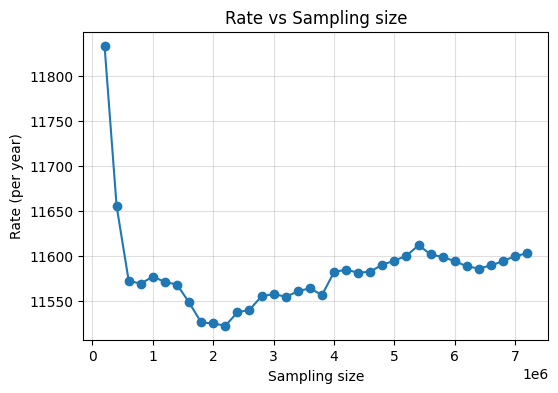

In [39]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_unlensed_grb2.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [47]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 6e6)[0]
# take average 
grb_rate_unlensed1 = np.mean(meta_data['total_rate'][idx])
print('Unlensed GRB Rate (per year) =', grb_rate_unlensed1)

Unlensed GRB Rate (per year) = 11593.122638132181


### Plots

In [41]:
unlensed_param_detectable = get_param_from_json("ler_data/n_unlensed_params_detectable_grb2.json")
zs = unlensed_param_detectable['zs']
viewing_angle = unlensed_param_detectable['theta_jn']
# radian to degree
viewing_angle = np.degrees(viewing_angle)
# if angle > 90, then angle = 180 - angle
viewing_angle[viewing_angle > 90] = viewing_angle[viewing_angle > 90]-90

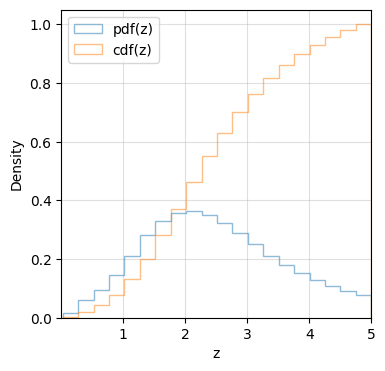

In [42]:
plt.figure(figsize=(4,4))
plt.hist(zs, bins=20, alpha=0.5, label='pdf(z)', density=True, histtype='step')
# cdf
plt.hist(zs, bins=20, alpha=0.5, label='cdf(z)', density=True, histtype='step', cumulative=True)
plt.xlabel('z')
plt.ylabel('Density')
plt.xlim(0.0001, 5)
plt.legend()
plt.grid(alpha=0.4)
plt.show()

* for comparison refer to Fig.4 [Perley et. al.](https://arxiv.org/pdf/1504.02482)

* my rate is lower than the above paper, in the local universe.

* local merger rate density considered in `ler` for the BNS is 150.5 Gpc^-3 yr^-1 

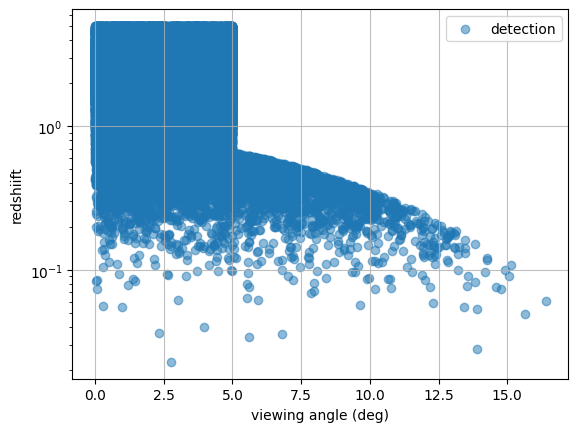

In [43]:
# blue: detection, red: non-detection
plt.scatter(viewing_angle, zs, c='C0', label="detection", alpha=0.5)

# draw a horizontal line for GW170817, 40Mpc
# plt.hlines(y=dl_to_z(40), xmin=min(angle)-1, xmax=max(angle)+1, colors='C3', linestyles='solid', label='40Mpc, GW170817')

plt.xlabel("viewing angle (deg)")
plt.ylabel("redshiift")
plt.yscale("log")
plt.legend()
plt.grid(alpha=0.8)
plt.show()

### Checking how many of these events are detectable in GWs

In [51]:
ler = LeR(
    verbose=False,
    z_max=5,
    event_type='BNS',
    mtot_max=51,
    ifos=['L1','H1','V1'],
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
)

In [52]:
snr_unlensed = ler.snr(gw_param_dict=unlensed_param_detectable)['optimal_snr_net']

In [48]:
# super-threshold only
# number of detectable events in terms of GW snr out of already detected events in term of GRB pdet
print(f"Number of unlensed detectable events in terms of GW snr is {np.sum(snr_unlensed>8)} \nout of {len(snr_unlensed)} events that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable unlensed GRBs is {grb_rate_unlensed1}, \nthen the rate of detectable GWs is {grb_rate_unlensed1*np.sum(snr_unlensed>8)/len(snr_unlensed)}\n")

print(f"ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = {len(snr_unlensed)/np.sum(snr_unlensed>8)}")

Number of unlensed detectable events in terms of GW snr is 35 
out of 200000 events that are already detected in terms of GRB pdet

if the rate of detectable unlensed GRBs is 11593.122638132181, 
then the rate of detectable GWs is 2.028796461673132

ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = 5714.285714285715


In [49]:
# sub-threshold considered
# number of detectable events in terms of GW snr out of already detected events in term of GRB pdet
print(f"Number of unlensed detectable events in terms of GW snr is {np.sum(snr_unlensed>6)} \nout of {len(snr_unlensed)} events that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable unlensed GRBs is {grb_rate_unlensed1}, \nthen the rate of detectable GWs is {grb_rate_unlensed1*np.sum(snr_unlensed>6)/len(snr_unlensed)}\n")

print(f"ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = {len(snr_unlensed)/np.sum(snr_unlensed>6)}")

Number of unlensed detectable events in terms of GW snr is 81 
out of 200000 events that are already detected in terms of GRB pdet

if the rate of detectable unlensed GRBs is 11593.122638132181, 
then the rate of detectable GWs is 4.695214668443533

ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = 2469.135802469136


### Lensed events

In [53]:
ler = LeR(
    npool=6,
    verbose=False,
    z_max=5,
    pdet_finder=pdet_calculator,
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
    event_type='BNS',
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [54]:
lensed_param_detectable = ler.selecting_n_lensed_detectable_events(
    size=50000,
    batch_size=200000,
    resume=True,
    trim_to_size=True,
    detectability_condition="pdet",
    output_jsonfile="n_lensed_params_detectable_grb2.json",
    meta_data_file="meta_lensed_grb2.json",
)

collected number of detectable events =  0


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.01it/s]


collected number of events =  2308
total number of events =  200000
total lensed rate (yr^-1): 9.014708118812555


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.61it/s]


collected number of events =  4617
total number of events =  400000
total lensed rate (yr^-1): 9.01666104518145


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.76it/s]


collected number of events =  7013
total number of events =  600000
total lensed rate (yr^-1): 9.130581750033572


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


collected number of events =  9410
total number of events =  800000
total lensed rate (yr^-1): 9.188518565644081


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.29it/s]


collected number of events =  11756
total number of events =  1000000
total lensed rate (yr^-1): 9.183440957084958


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.03it/s]


collected number of events =  14075
total number of events =  1200000
total lensed rate (yr^-1): 9.162479547392167


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


collected number of events =  16525
total number of events =  1400000
total lensed rate (yr^-1): 9.22060235599019


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.49it/s]


collected number of events =  18891
total number of events =  1600000
total lensed rate (yr^-1): 9.22318300869194


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


collected number of events =  21229
total number of events =  1800000
total lensed rate (yr^-1): 9.213038641164633


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.63it/s]


collected number of events =  23658
total number of events =  2000000
total lensed rate (yr^-1): 9.240466407056648


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.31it/s]


collected number of events =  26009
total number of events =  2200000
total lensed rate (yr^-1): 9.235211259736717


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


collected number of events =  28390
total number of events =  2400000
total lensed rate (yr^-1): 9.240596602147908


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.35it/s]


collected number of events =  30755
total number of events =  2600000
total lensed rate (yr^-1): 9.24034622697241


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.37it/s]


collected number of events =  33096
total number of events =  2800000
total lensed rate (yr^-1): 9.233435872128632


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.51it/s]


collected number of events =  35420
total number of events =  3000000
total lensed rate (yr^-1): 9.223020264827868


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.29it/s]


collected number of events =  37834
total number of events =  3200000
total lensed rate (yr^-1): 9.23587703008975


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.03it/s]


collected number of events =  40183
total number of events =  3400000
total lensed rate (yr^-1): 9.232287091911635


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


collected number of events =  42483
total number of events =  3600000
total lensed rate (yr^-1): 9.218463436633781


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.01it/s]


collected number of events =  44876
total number of events =  3800000
total lensed rate (yr^-1): 9.225213024259608


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.44it/s]


collected number of events =  47214
total number of events =  4000000
total lensed rate (yr^-1): 9.220546558093936


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.54it/s]


collected number of events =  49629
total number of events =  4200000
total lensed rate (yr^-1): 9.230645977315927


100%|█████████████████████████████████████████████████████| 200000/200000 [00:51<00:00, 3906.86it/s]


collected number of events =  51985
total number of events =  4400000
total lensed rate (yr^-1): 9.229352480630036
storing detectable lensed params in ./ler_data/n_lensed_params_detectable_grb2.json

 trmming final result to size=50000


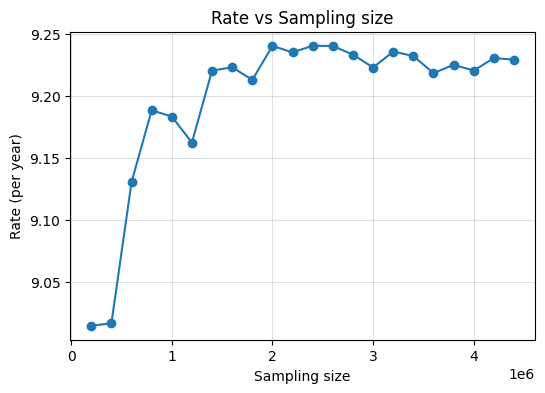

In [55]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_lensed_grb2.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [56]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 3e6)[0]
# take average 
grb_rate_lensed = np.mean(meta_data['total_rate'][idx])
print('Lensed GRB Rate (per year) =', grb_rate_lensed)

Lensed GRB Rate (per year) = 9.22748365699067


### Plots

In [57]:
lensed_param_detectable = get_param_from_json("ler_data/n_lensed_params_detectable_grb2.json")
zs = lensed_param_detectable['zs']
viewing_angle = lensed_param_detectable['theta_jn']
# radian to degree
viewing_angle = np.degrees(viewing_angle)
# if angle > 90, then angle = 180 - angle
viewing_angle[viewing_angle > 90] = viewing_angle[viewing_angle > 90]-90

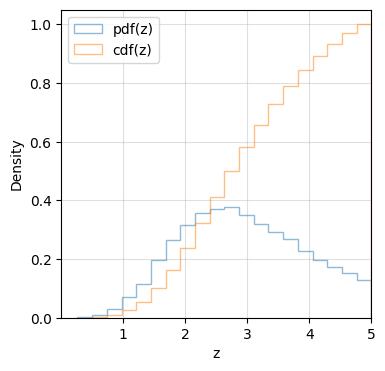

In [58]:
plt.figure(figsize=(4,4))
plt.hist(zs, bins=20, alpha=0.5, label='pdf(z)', density=True, histtype='step')
# cdf
plt.hist(zs, bins=20, alpha=0.5, label='cdf(z)', density=True, histtype='step', cumulative=True)
plt.xlabel('z')
plt.ylabel('Density')
plt.xlim(0.0001, 5)
plt.legend()
plt.grid(alpha=0.4)
plt.show()

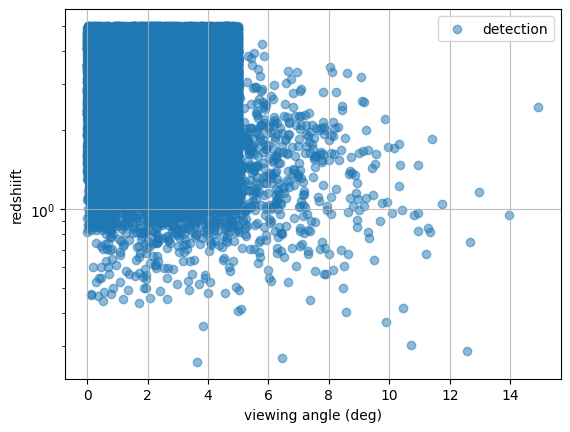

In [59]:
# blue: detection, red: non-detection
plt.scatter(viewing_angle, zs, c='C0', label="detection", alpha=0.5)

# draw a horizontal line for GW170817, 40Mpc
# plt.hlines(y=dl_to_z(40), xmin=min(angle)-1, xmax=max(angle)+1, colors='C3', linestyles='solid', label='40Mpc, GW170817')

plt.xlabel("viewing angle (deg)")
plt.ylabel("redshiift")
plt.yscale("log")
plt.legend()
plt.grid(alpha=0.8)
plt.show()

* at high redshift (z>1), detection of off-axis GRBs is still possible for the lensed case, but not for the unlensed case.

### Out of the detected GRB events, how many are detectable in GW.

* find out GW detector SNRs of the event which are detectable in GRBs.

* check how many of them cross the SNR threshold

In [60]:
# ler initialization with default snr calculator (gwsnr)
ler = LeR(
    verbose=False,
    z_max=5,
    event_type='BNS',
    mtot_max=51,
    ifos=['L1','H1','V1'],
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
)

In [61]:
# get snr for the lensed events
snr_lensed, _ = ler.get_lensed_snrs(lensed_param_detectable, list_of_detectors=['L1','H1','V1'], snr_calculator=ler.snr)
snr_lensed = snr_lensed['optimal_snr_net']

In [62]:
# only super-threshold events
num_ =  np.sum(np.sum(snr_lensed>8, axis=1)>=2)
print(f"Number of lensed detectable events in terms of GW snr is {num_} out of {len(snr_lensed)} \nevents that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable lensed GRBs is {grb_rate_lensed}, \nthen the rate of detectable GWs is {grb_rate_lensed*num_/len(snr_lensed)}\n")

print(f"ratio (lensed detectable GRBs)/(lensed detectable GWs) = {len(snr_lensed)/num_}")

Number of lensed detectable events in terms of GW snr is 20 out of 50000 
events that are already detected in terms of GRB pdet

if the rate of detectable lensed GRBs is 9.22748365699067, 
then the rate of detectable GWs is 0.003690993462796268

ratio (lensed detectable GRBs)/(lensed detectable GWs) = 2500.0


In [63]:
# sub-threshold events considered
num_ =  np.sum(np.sum(snr_lensed>6, axis=1)>=2)
print(f"Number of lensed detectable events in terms of GW snr is {num_} out of {len(snr_lensed)} \nevents that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable lensed GRBs is {grb_rate_lensed}, \nthen the rate of detectable GWs is {grb_rate_lensed*num_/len(snr_lensed)}\n")

print(f"ratio (lensed detectable GRBs)/(lensed detectable GWs) = {len(snr_lensed)/num_}")

Number of lensed detectable events in terms of GW snr is 53 out of 50000 
events that are already detected in terms of GRB pdet

if the rate of detectable lensed GRBs is 9.22748365699067, 
then the rate of detectable GWs is 0.00978113267641011

ratio (lensed detectable GRBs)/(lensed detectable GWs) = 943.3962264150944


## results

### Table for GRB and GW number of events

| Event | Unlensed | Lensed | ratio(Unlensed/Lensed) |
| --- | --- | --- | --- |
| GRB | 11593.12 | 9.23 | 1:1256.03 |
| GW | 4.69 | 9.78e-3 | 1:479.55 |
| ratio(GW/GRB) | 1:2469.13 | 1:943.39 | - |

## GW detection first

### Unlensed events

In [13]:
# from ler.rates import LeR
# from ler.utils import get_param_from_json

ler = LeR(
    verbose=False,
    z_max=5,
    event_type='BNS',
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [17]:
unlensed_param_detectable = ler.selecting_n_unlensed_detectable_events(
    size=1000,
    batch_size=200000,
    snr_threshold=8.0,
    resume=True,
    trim_to_size=True,
    output_jsonfile="n_unlensed_params_detectable_gw.json",
    meta_data_file="meta_unlensed_gw.json",
)

collected number of detectable events =  1000
storing detectable unlensed params in ./ler_data/n_unlensed_params_detectable_gw.json

 trmming final result to size=1000


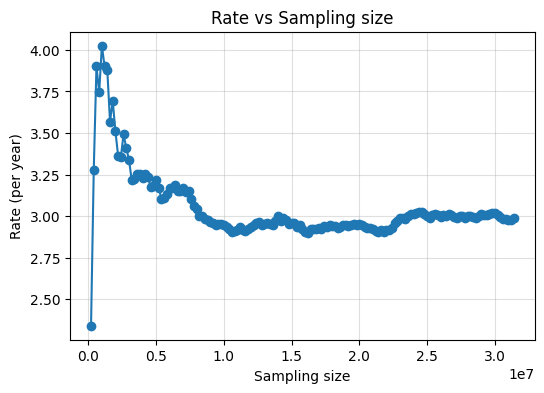

In [21]:
# rate
meta_data= get_param_from_json("ler_data/meta_unlensed_gw.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [22]:
# select only events after sampling size of
idx = np.where(meta_data['events_total'] > 2.5e7)[0]
# take average
rate_unlensed = np.mean(meta_data['total_rate'][idx])
print('Unlensed GW Rate (per year) =', rate_unlensed)

Unlensed GW Rate (per year) = 2.998817861475392


### How many detectable events are there in terms of GRB pdet out of already detected events in terms of GW snr?

In [18]:
unlensed_grb_pdet = pdet_calculator(unlensed_param_detectable)

In [24]:
# number of detectable events in terms of GRB pdet out of already detected events in term of GW snr
print(f"Number of unlensed detectable events in terms of GRB pdet is {np.sum(unlensed_grb_pdet['pdet_net']==1)} \nout of {len(unlensed_grb_pdet['pdet_net'])} events that are already detected in terms of GW snr\n")

print(f"if the rate of detectable unlensed GWs is {3.0}, \nthen the rate of detectable GRBs is {3.0*np.sum(unlensed_grb_pdet['pdet_net']==1)/len(unlensed_grb_pdet['pdet_net'])}\n")

print(f"ratio (unlensed detectable GWs)/(unlensed detectable GRBs) = {len(unlensed_grb_pdet['pdet_net'])/np.sum(unlensed_grb_pdet['pdet_net']==1)}")

Number of unlensed detectable events in terms of GRB pdet is 41 
out of 1000 events that are already detected in terms of GW snr

if the rate of detectable unlensed GWs is 3.0, 
then the rate of detectable GRBs is 0.123

ratio (unlensed detectable GWs)/(unlensed detectable GRBs) = 24.390243902439025


### Lensed events

In [18]:
ler = LeR(
    verbose=False,
    z_max=5,
    event_type='BNS',
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [13]:
# sub-threshold events considered
lensed_param_detectable = ler.selecting_n_lensed_detectable_events(
    size=10000,
    batch_size=200000,
    snr_threshold=[6.0,6.0],
    num_img=[1,1],
    resume=True,
    output_jsonfile="n_lensed_params_detectable_gw.json",
    meta_data_file="meta_lensed_gw.json",
)

collected number of detectable events =  10016.0
storing detectable lensed params in ./ler_data/n_lensed_params_detectable_gw.json

 trmming final result to size=10000


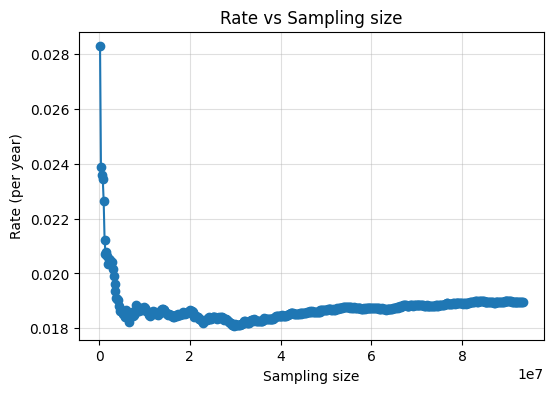

In [14]:
# rate 
meta_data= get_param_from_json("ler_data/meta_lensed_gw.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [15]:
# select only events after sampling size of
idx = np.where(meta_data['events_total'] > 1.5e7)[0]
# take average
rate_lensed_sub = np.mean(meta_data['total_rate'][idx])
print('Lensed GW Rate (per year, sub-threshold considered) =', rate_lensed_sub)

# check how many of the events are super-threshold
snr_lensed = lensed_param_detectable['optimal_snr_net']
# only super-threshold events
num_ =  np.sum(np.sum(snr_lensed>8, axis=1)>=2)

rate_lensed_super = rate_lensed_sub*num_/len(snr_lensed)
print('Lensed GW Rate (per year, super-threshold considered) =', rate_lensed_super)

Lensed GW Rate (per year, sub-threshold considered) = 0.01864766308762467
Lensed GW Rate (per year, super-threshold considered) = 0.006632973760268095


In [16]:
# save the data for new_lensed_param_detectable
new_lensed_param_detectable = lensed_param_detectable.copy()

# select only super-threshold events
idx = np.where(np.sum(snr_lensed>8, axis=1)>=2)[0]
for key in new_lensed_param_detectable.keys():
    new_lensed_param_detectable[key] = new_lensed_param_detectable[key][idx]

# save the data
from ler.utils import append_json

lensed_param_detectable = append_json("ler_data/n_lensed_params_detectable_gw_super.json", new_lensed_param_detectable, replace=True)

### How many detectable events are there in terms of GRB pdet out of already detected events in terms of GW snr?

In [27]:
# get snr for the lensed events
pdet_lensed,_ = ler.get_lensed_snrs(
    lensed_param=lensed_param_detectable,
    list_of_detectors=['L1','H1','V1'],
    pdet_calculator=pdet_calculator,
)

# only detectable GRBs
num_ =  np.sum(np.sum(pdet_lensed['pdet_net']==1, axis=1)>=2)

In [31]:
# number of detectable events in terms of GRB pdet out of already detected events in term of GW snr
print(f"Number of lensed detectable events in terms of GRB pdet is {num_} \nout of {len(pdet_lensed['pdet_net'])} events that are already detected in terms of GW snr\n")

print(f"if the rate of detectable lensed GWs is {0.00663}, \nthen the rate of detectable GRBs is {0.00663*num_/len(pdet_lensed['pdet_net'])}\n")

print(f"ratio (lensed detectable GWs)/(lensed detectable GRBs) = {len(pdet_lensed['pdet_net'])/num_}")



Number of lensed detectable events in terms of GRB pdet is 82 
out of 3557 events that are already detected in terms of GW snr

if the rate of detectable lensed GWs is 0.00663, 
then the rate of detectable GRBs is 0.0001528422828226033

ratio (lensed detectable GWs)/(lensed detectable GRBs) = 43.3780487804878


## Final results

### Table for GRB and GW rates

| Event | Unlensed | Lensed | ratio(Unlensed/Lensed) |
| --- | --- | --- | --- |
| GW | 3.0 | 6.63e-3 | 1:452.83 |
| GRB | 0.123 | 1.54-4 | 1:12520.33 |
| ratio(GW/GRB) | 24.39 | 4.31 | - |


Important takeaways:

Unlensed (detectable): out of 24 GW BNS events, we can expect 1 GRB counter part.

Lensed (detectable): out of 4 GW BNS events, we can expect 1 GRB counter part.